# Model Zoo -- Convolutional Netural Network

Nothing special here, just a basic cnn to test out the dataset.

## Imports

In [19]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import pdb

import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchsummary

In [2]:
from tqdm import tnrange, tqdm_notebook

In [3]:
## to make pytorch reproducible 
# np.random.seed(8)
# torch.manual_seed(8)
# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True  # this will impact performance
#     torch.backends.cudnn.benchmark = False  #  enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware
# torch.manual_seed(random_seed)

## Settings and Dataset

In [4]:
#############################
## Settings
#############################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10

In [5]:
################################
## MNIST Dataset
################################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

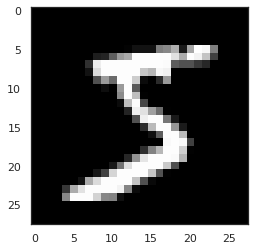

In [6]:
plt.imshow(train_dataset[0][0].squeeze().numpy(), cmap='gray');

In [7]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [8]:
# Checking the dataset
for name, dataset in zip(['train', 'test'], [train_loader, test_loader]):
    print(f'============ {name} : {len(dataset.dataset):,} ============')
    for images, labels in dataset:
        
        print('Image batch dimension', images.shape)
        print('Image label dimension', labels.shape)
        break

============ train : 60,000 ============
Image batch dimension torch.Size([128, 1, 28, 28])
Image label dimension torch.Size([128])
============ test : 10,000 ============
Image batch dimension torch.Size([128, 1, 28, 28])
Image label dimension torch.Size([128])


## Model

In [9]:
######################
### Model
######################

## TODO: I think the channels out are wrong
## TODO: need to normalize the images
## TODO: After notebook can run, create the train/val split notebook

class ConvNet(torch.nn.Module):
    
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w -k + 2*p)/s + 1 = 0
        # => p = (s(o-1)) - w + k)/2
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1, 
                                      out_channels=4,
                                      kernel_size=(3,3),
                                      stride=(1,1),
                                      padding=1)  # (1(28-1) - 28 + 3) / 2 = 1
        
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2,2),
                                         stride=(2,2),
                                         padding=0)  # (2(14-1) - 28 + 2) = 0
        
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=16,
                                      kernel_size=(3,3),
                                      stride=(1,1),
                                      padding=1) # (1(14-1) - 14 + 4) / 2 = 1
        
        # 14x14x8 => 7x7x8
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2,2),
                                         stride=(2,2),
                                         padding=0) # (2(2-1) - 14 +2) = 0
        
        self.linear_1 = torch.nn.Linear(7*7*16, num_classes)
        
        # optionally initialize weights from Gaussian;
        # Guassian weight init is not recommended and only for demonstration purposes
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                m.weight.data.normal_(0.0, 0.01)
                m.bias.data.zero_()
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)

        logits = self.linear_1(out.view(-1, 7*7*16))
        return logits

In [10]:
model = ConvNet(num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
torchsummary.summary(model, (1, 28, 28), batch_size=batch_size, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 4, 28, 28]              40
         MaxPool2d-2           [128, 4, 14, 14]               0
            Conv2d-3          [128, 16, 14, 14]             592
         MaxPool2d-4            [128, 16, 7, 7]               0
            Linear-5                  [128, 10]           7,850
Total params: 8,482
Trainable params: 8,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 7.67
Params size (MB): 0.03
Estimated Total Size (MB): 8.08
----------------------------------------------------------------


## Training

In [12]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [13]:
## create a train_model function isntead of current approach. 

## need to calcualte the cost functionf or validation

## Need to make sure I have tdmp notebook updator

## for print out
## just end of epoch, validation
# time between each epoch?
# or just total time...?


## For graph
## save all batch.
## when of epoch as darker dot
## also save validation set
## 

In [14]:
# start_time = time.time()    
# for epoch in tnrange(num_epochs):
#     model = model.train()
#     for batch_idx, (features, targets) in tqdm_notebook(enumerate(train_loader), desc='batch', leave=False, total=len(train_loader)):
        
#         features = features.to(device)
#         targets = targets.to(device)

#         ### FORWARD AND BACK PROP
#         logits, probas = model(features)
#         cost = F.cross_entropy(logits, targets)
#         optimizer.zero_grad()
        
#         cost.backward()
        
#         ### UPDATE MODEL PARAMETERS
#         optimizer.step()
        
# #         ### LOGGING
# #         if not batch_idx % 50:
# #             print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
# #                    %(epoch+1, num_epochs, batch_idx, 
# #                      len(train_loader), cost))
    
# #     ### LOGGING
# #     print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
# #                    %(epoch+1, num_epochs, batch_idx, 
# #                      len(train_loader), cost))
    
# #     model = model.eval()
# #     print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
# #           epoch+1, num_epochs, 
# #           compute_accuracy(model, test_loader)))

    
# #     print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
#     # if verbose print
#     print(f'Epoch: {epoch}/{num_epoch:03d} Cost: {cost:.4f}', end=" | ")
    
#     model = model.eval()
#     print(f'Val Cost: {tmp4:.4f} Acc: {tmp5:.2f}%', end=" | ")
    
#     print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    
# print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [15]:
criterion = torch.nn.CrossEntropyLoss()

In [16]:
dataloaders = {'train': train_loader,
               'val': test_loader}
dataset_sizes = {'train': len(train_dataset),
                'val': len(test_dataset)}

In [17]:
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=25):
    since = time.time()
    
    batch_loss_record = []
    val_loss_record = []
    
    for epoch in tnrange(num_epochs):
        print(f'Epoch {epoch:03d}/{num_epochs - 1:03d}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler: scheduler.step()
                model.train()
            else:
                model.eval()
                running_loss = 0.0
                running_corrects = 0
                
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        batch_loss_record.append(loss.item())
                    else:
                        # validation
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
#                 pdb.set_trace()
                print(f'{phase} Batch Loss: {loss.item():.4f} Batch Acc: {torch.sum(preds == labels).double() / inputs.size(0):.4f}', end = " | ")
            else:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                val_loss_record.append(epoch_loss)
        
    time_elapsed = time.time() - since
    print('training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    return batch_loss_record, val_loss_record

In [18]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 1.2430 Batch Acc: 0.5729 | val Loss: 1.3597 Acc: 0.5603
Epoch 001/009
----------
train Batch Loss: 0.1918 Batch Acc: 0.9479 | val Loss: 0.2100 Acc: 0.9390
Epoch 002/009
----------
train Batch Loss: 0.1536 Batch Acc: 0.9479 | val Loss: 0.1349 Acc: 0.9583
Epoch 003/009
----------
train Batch Loss: 0.2293 Batch Acc: 0.9375 | val Loss: 0.1189 Acc: 0.9648
Epoch 004/009
----------
train Batch Loss: 0.0472 Batch Acc: 0.9896 | val Loss: 0.0988 Acc: 0.9703
Epoch 005/009
----------
train Batch Loss: 0.0633 Batch Acc: 0.9792 | val Loss: 0.1018 Acc: 0.9693
Epoch 006/009
----------
train Batch Loss: 0.0799 Batch Acc: 0.9688 | val Loss: 0.0827 Acc: 0.9743
Epoch 007/009
----------
train Batch Loss: 0.0997 Batch Acc: 0.9583 | val Loss: 0.0774 Acc: 0.9754
Epoch 008/009
----------
train Batch Loss: 0.1375 Batch Acc: 0.9479 | val Loss: 0.1247 Acc: 0.9614
Epoch 009/009
----------
train Batch Loss: 0.1068 Batch Acc: 0.9896 | val Loss: 0.0672 Acc: 0.9771

training 

In [18]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 2.3068 Batch Acc: 0.0833 | val Loss: 2.3010 Acc: 0.1135
Epoch 001/009
----------
train Batch Loss: 2.3124 Batch Acc: 0.0625 | val Loss: 2.3004 Acc: 0.1135
Epoch 002/009
----------
train Batch Loss: 0.3391 Batch Acc: 0.8958 | val Loss: 0.3971 Acc: 0.8827
Epoch 003/009
----------
train Batch Loss: 0.2923 Batch Acc: 0.8958 | val Loss: 0.2381 Acc: 0.9261
Epoch 004/009
----------
train Batch Loss: 0.1450 Batch Acc: 0.9479 | val Loss: 0.1276 Acc: 0.9617
Epoch 005/009
----------
train Batch Loss: 0.2747 Batch Acc: 0.9583 | val Loss: 0.1037 Acc: 0.9679
Epoch 006/009
----------
train Batch Loss: 0.1809 Batch Acc: 0.9271 | val Loss: 0.0908 Acc: 0.9710
Epoch 007/009
----------
train Batch Loss: 0.0801 Batch Acc: 0.9583 | val Loss: 0.0896 Acc: 0.9688
Epoch 008/009
----------
train Batch Loss: 0.0755 Batch Acc: 0.9792 | val Loss: 0.0692 Acc: 0.9759
Epoch 009/009
----------
train Batch Loss: 0.0976 Batch Acc: 0.9896 | val Loss: 0.0713 Acc: 0.9761

training 

In [20]:
tmp = torch.randint(0, 10, size=(2,3,4))

In [23]:
tmp

tensor([[[8, 1, 8, 8],
         [7, 7, 7, 4],
         [5, 6, 2, 8]],

        [[0, 2, 3, 0],
         [0, 3, 6, 8],
         [0, 0, 2, 9]]])

In [24]:
tmp.data

tensor([[[8, 1, 8, 8],
         [7, 7, 7, 4],
         [5, 6, 2, 8]],

        [[0, 2, 3, 0],
         [0, 3, 6, 8],
         [0, 0, 2, 9]]])

In [16]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 2.2919 Batch Acc: 0.0000 | val Loss: 2.2808 Acc: 0.2452
Epoch 001/009
----------
train Batch Loss: 0.2125 Batch Acc: 0.0000 | val Loss: 0.2333 Acc: 0.9337
Epoch 002/009
----------
train Batch Loss: 0.2638 Batch Acc: 0.0000 | val Loss: 0.1556 Acc: 0.9523
Epoch 003/009
----------
train Batch Loss: 0.1145 Batch Acc: 0.0000 | val Loss: 0.1213 Acc: 0.9625
Epoch 004/009
----------
train Batch Loss: 0.0463 Batch Acc: 0.0000 | val Loss: 0.0966 Acc: 0.9695
Epoch 005/009
----------
train Batch Loss: 0.1713 Batch Acc: 0.0000 | val Loss: 0.0891 Acc: 0.9716
Epoch 006/009
----------
train Batch Loss: 0.0745 Batch Acc: 0.0000 | val Loss: 0.0967 Acc: 0.9676
Epoch 007/009
----------
train Batch Loss: 0.0408 Batch Acc: 0.0000 | val Loss: 0.0740 Acc: 0.9764
Epoch 008/009
----------
train Batch Loss: 0.2236 Batch Acc: 0.0000 | val Loss: 0.1028 Acc: 0.9659
Epoch 009/009
----------
train Batch Loss: 0.0462 Batch Acc: 1.0000 | val Loss: 0.0658 Acc: 0.9792

training 

In [17]:
len(batch_loss)

4690

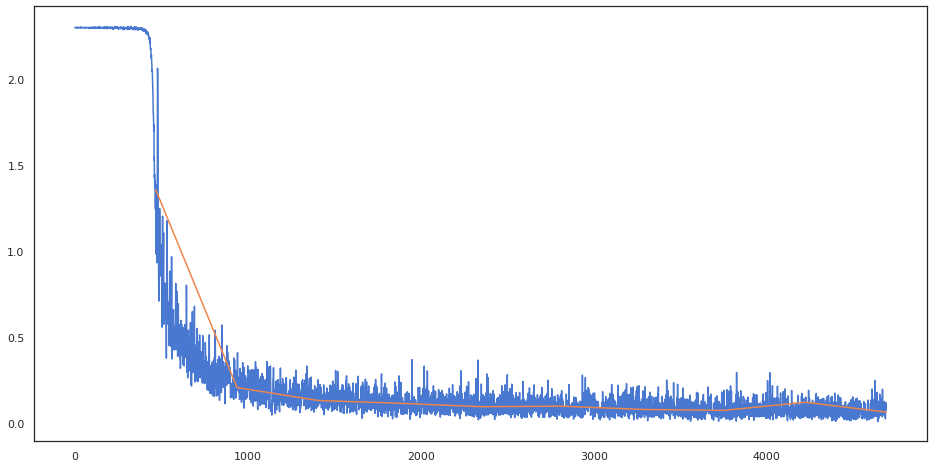

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(np.arange(len(batch_loss)), batch_loss, ax=ax)
sns.lineplot(np.arange(1, num_epochs+1)*len(dataloaders['train']), val_loss, ax=ax)
# add legend